In [1]:
# Generate batches for dataloader
import pickle5 as pickle
import torch
import pandas as pd
import numpy as np
import collections

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
df = pd.read_csv('data/LigID_pdbchain_partitions.csv')
with open('data/multi_ion.pkl', 'rb') as f:
    data_dict = pickle.load(f)

In [2]:
import numpy as np
import os
from utils import ProtEmbDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'

In [3]:
# External validation of fold 6 
# All labels considered (nx11)
import torch
from models import IonicProtein
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data as data
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import collections
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
m = nn.Sigmoid()

fields = ['CA','CO','CU','FE2','FE','MG','MN','PO4','SO4','ZN', 'null']
label_dict = dict.fromkeys(fields, [])
# inference_dict = dict.fromkeys(df[df['partitions']==6]['pdb_chain'].values)

# figure, axes = plt.subplots(2,5, figsize=(12,5), sharey=True, sharex=True)
# axes_ = axes.flatten()

# model_list = ['esm1b_t33_650M_UR50S', 'esm1_t34_670M_UR50D', 'esm1_t34_670M_UR50S',
#                 'esm2_t12_35M_UR50D', 'esm2_t30_150M_UR50D', 'esm2_t33_650M_UR50D',
#                 'esm2_t6_8M_UR50D']

model_list = ['esm2_t33_650M_UR50D']

perf_dict_foldwise = {k: [] for k in range(1,6)}
pred_dict_foldwise = {k: [] for k in range(1,6)}
for cpt_fold in range(1,6):
    for model_name in model_list:
        perf_dict = {k: [] for k in fields}
        perd_dict = {k: [] for k in fields}
        # Prepare holdout_set
        holdout_batches = []
        holdout_fold = 6
        for datapoint in os.listdir(data_path+model_name+'_multiclass_batch64_CV/'):
            if datapoint.endswith('fold%s.pickle'%(holdout_fold)):
                holdout_batches.append(datapoint)
            else:
                pass

        data_list = np.array(os.listdir(data_path+model_name+'_multiclass_batch64_CV/'))
        holdout_indices = list(np.where(np.isin(data_list, holdout_batches))[0])
        protein_dataset = ProtEmbDataset(model_name)
        sampler_holdout = SubsetRandomSampler(holdout_indices)
        dataloader_holdout = DataLoader(protein_dataset, batch_size=1, sampler = sampler_holdout, num_workers=4)

        #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        device = 'cpu'      # For inference
        trained_model = IonicProtein(dataloader_holdout.dataset[0][0].shape[1]).to(device)
        trained_model.load_state_dict(torch.load('checkpoints_multiclass_weighted/%s_setB_fold%s.pt'%(model_name, cpt_fold)))
        trained_model.eval()

        for ion in tqdm(fields):
            ion_index = fields.index(ion)   # Index of the ion under consideration
            if ion=='null':
                continue
            embs_merged, labels_merged = [], []
            for pdbid in df[df['partitions']==6]['pdbchain'].values: # Run inference on partition 6
                if ion in data_dict[pdbid]['ions'].keys():
                #if data_dict[pdbid][2]==ion:   # Ion wise segregation of holdout set
                    emb = torch.load(data_path+model_name+'/'+pdbid+'.pt')
                    key = list(emb['representations'].keys())
                    emb = emb['representations'][key[0]]
                    embs_merged.append(emb)

                    # Initalize label_array
                    label_list = [int(a) for a in data_dict[pdbid]['ions'][ion]]
                    label_array = np.array([[0]*len(emb)]*len(fields))
                    null_label = np.ones(len(label_list))
                    null_label[np.where(label_list==1)[0]]=0

                    # populate label_array
                    label_array[ion_index] = label_list
                    label_array[10]=null_label
                    label_array = torch.from_numpy(label_array)
                    labels_merged.append(label_array.T)

            embs_merged = torch.cat(embs_merged)
            labels_merged = torch.cat(labels_merged)
            predictions = trained_model(embs_merged.to(device), mask=None)
            
            predictions_sigmoid = m(torch.stack(predictions))
            predictions_binary = torch.round(predictions_sigmoid)
            
            mcc_flattened = matthews_corrcoef(labels_merged.T.flatten().cpu().detach().numpy(),
                                            predictions_binary.flatten().cpu().detach().numpy())
            
            mcc_sliced = matthews_corrcoef(labels_merged.T[ion_index].cpu().detach().numpy(),
                                        predictions_binary[ion_index].cpu().detach().numpy())

            roc_auc = roc_auc_score(labels_merged.T[ion_index].cpu().data.numpy(),
                                    predictions_sigmoid[ion_index].cpu().data.numpy())
            fpr, tpr, threshold = roc_curve(labels_merged.T[ion_index].cpu().data.numpy(), 
                                            predictions_sigmoid[ion_index].cpu().data.numpy())
            precision, recall, thresholds = precision_recall_curve(labels_merged.T[ion_index].cpu().data.numpy(), 
                                                                predictions_sigmoid[ion_index].cpu().data.numpy())
            aupr = average_precision_score(labels_merged.T[ion_index].cpu().data.numpy(), 
                                        predictions_sigmoid[ion_index].cpu().data.numpy())

            # perf_stats = {'fpr':fpr, 'tpr':tpr, 'auroc':roc_auc, 'mcc':mcc_sliced, 'aupr':aupr,
            #     'precision':precision, 'recall':recall}
            # perf_dict[ion] = perf_stats

            pred_stats = {'pred_sigmoid':predictions_sigmoid, 'pred_binary':predictions_binary, 'labels':labels_merged.T}
            perd_dict[ion] = pred_stats

        #perf_dict_foldwise[cpt_fold] = perf_dict
        pred_dict_foldwise[cpt_fold] = perd_dict
            #print(ion, mcc_flattened, mcc_sliced, roc_auc, aupr)

    #         axes_[ion_index].plot(recall, precision, label='auroc:%s'%(round(roc_auc,2)))
    #         axes_[ion_index].plot(fpr, tpr, color='black', label='aupr:%s'%(round(aupr,2)))
    #         axes_[ion_index].set_xlabel('Recall/fpr')
    #         axes_[ion_index].set_ylabel('Precision/tpr')

    #         axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.5)
    #         axes_[ion_index].legend()
    #         axes_[ion_index].set_title(ion+' (MCC:%s)'%(round(mcc_sliced, 2)))
    # figure.suptitle('Multi-ion training performance for %s'%(model_name), fontweight='bold')
    # plt.tight_layout()
    break

# with open('results/'+model_name+'multi_perf_foldwise.pickle', 'wb') as handle:
#     pickle.dump(perf_dict_foldwise, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('results/'+model_name+'multi_pred_foldwise.pickle', 'wb') as handle:
    pickle.dump(perf_dict_foldwise, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #plt.savefig('plots/performance_weighted_multiclass.png', bbox_inches='tight', dpi=300, facecolor=figure.get_facecolor())

449


 82%|████████▏ | 9/11 [01:04<00:12,  6.26s/it]

## For genearting ext val pkl file multiclass

In [ ]:
# External validation of fold 6 
# All labels considered (nx11)
# Generate batches for dataloader
import pickle5 as pickle
import torch
import pandas as pd
import collections

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
df = pd.read_csv('data/LigID_pdbchain_partitions.csv')
with open('data/multi_ion.pkl', 'rb') as f:
    data_dict = pickle.load(f)

import numpy as np
import os
from utils import ProtEmbDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
    
import torch
from models import IonicProtein
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data as data
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import collections
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
m = nn.Sigmoid()

fields = ['CA','CO','CU','FE2','FE','MG','MN','PO4','SO4','ZN', 'null']
label_dict = dict.fromkeys(fields, [])
# inference_dict = dict.fromkeys(df[df['partitions']==6]['pdb_chain'].values)

# figure, axes = plt.subplots(2,5, figsize=(12,5), sharey=True, sharex=True)
# axes_ = axes.flatten()

# model_list = ['esm1b_t33_650M_UR50S', 'esm1_t34_670M_UR50D', 'esm1_t34_670M_UR50S',
#                 'esm2_t12_35M_UR50D', 'esm2_t30_150M_UR50D', 'esm2_t33_650M_UR50D',
#                 'esm2_t6_8M_UR50D']

model_name = 'esm2_t33_650M_UR50D'

perf_dict_foldwise = {k: [] for k in range(1,6)}
pred_dict_foldwise = {k: [] for k in range(1,6)}
for cpt_fold in range(1,6):
    perf_dict = {k: [] for k in fields}
    perd_dict = {k: [] for k in fields}
    # Prepare holdout_set
    holdout_batches = []
    holdout_fold = 6
    for datapoint in os.listdir(data_path+model_name+'_multiclass_batch64_CV/'):
        if datapoint.endswith('fold%s.pickle'%(holdout_fold)):
            holdout_batches.append(datapoint)
        else:
            pass

    data_list = np.array(os.listdir(data_path+model_name+'_multiclass_batch64_CV/'))
    holdout_indices = list(np.where(np.isin(data_list, holdout_batches))[0])
    protein_dataset = ProtEmbDataset(model_name)
    sampler_holdout = SubsetRandomSampler(holdout_indices)
    dataloader_holdout = DataLoader(protein_dataset, batch_size=1, sampler = sampler_holdout, num_workers=4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device = 'cpu'      # For inference
    trained_model = IonicProtein(dataloader_holdout.dataset[0][0].shape[1]).to(device)
    trained_model.load_state_dict(torch.load('checkpoints_multiclass_weighted/%s_setB_fold%s.pt'%(model_name, cpt_fold)))
    trained_model.eval()

    embs_merged, labels_merged = [], []
    label_dict = {k: [] for k in fields}
    for pdbid in df[df['partitions']==6]['pdbchain'].values: # Run inference on partition 6
        emb = torch.load(data_path+model_name+'/'+pdbid+'.pt')
        key = list(emb['representations'].keys())
        emb = emb['representations'][key[0]]
        embs_merged.append(emb)

        # Prepare multiclass labels
        for ion in fields:
            if ion in data_dict[pdbid]['ions'].keys():
                labels = [int(a) for a in data_dict[pdbid]['ions'][ion]]
                label_dict[ion].append(labels)
            else:
                label_dict[ion].append([0]*len(emb))
    
    embs_merged = torch.cat(embs_merged)
    for ion in label_dict.keys():
        label_dict[ion] = np.array([item for sublist in label_dict[ion] for item in sublist])
    null_label = np.ones(len(embs_merged))   # Add null label
    for ion in label_dict.keys(): 
        null_label[np.where(label_dict[ion]==1)[0]]=0
    label_dict['null']=null_label
    labels_merged = torch.stack([torch.squeeze(torch.tensor(label_dict[key], dtype=float)).to(device) for key in fields]).T

    predictions = trained_model(embs_merged.to(device), mask=None)
    break
#     predictions_sigmoid = m(torch.stack(predictions))
#     predictions_binary = torch.round(predictions_sigmoid)


#     pred_stats = {'pred_sigmoid':predictions_sigmoid, 'pred_binary':predictions_binary, 'labels':labels_merged.T}
#     perd_dict[ion] = pred_stats

# #perf_dict_foldwise[cpt_fold] = perf_dict
# pred_dict_foldwise[cpt_fold] = perd_dict
        

In [3]:
embs_merged.shape, labels_merged.shape

(torch.Size([951257, 1280]), torch.Size([951257, 11]))

In [4]:
predictions = trained_model(embs_merged, mask=None)

In [23]:
torch.cat(embs_merged).shape, labels_merged.shape

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [7]:
labels_ = [torch.squeeze(torch.tensor(label_dict[key], dtype=float)).to(device) for key in fields]
torch.stack(labels_)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]], dtype=torch.float64)

In [14]:
a

{1: {'CA': [],
  'CO': [],
  'CU': [],
  'FE2': [],
  'FE': [],
  'MG': [],
  'MN': [],
  'PO4': [],
  'SO4': [],
  'ZN': [],
  'null': []},
 2: [None],
 3: [None],
 4: [None],
 5: [None]}

In [8]:
perf_dict = {k: [] for k in fields}

In [6]:
mcc_sliced

0.7648857716942514

(array([0.        , 0.        , 0.        , ..., 0.99873662, 0.99874286,
        1.        ]),
 array([0.00000000e+00, 2.05338809e-04, 6.16016427e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))

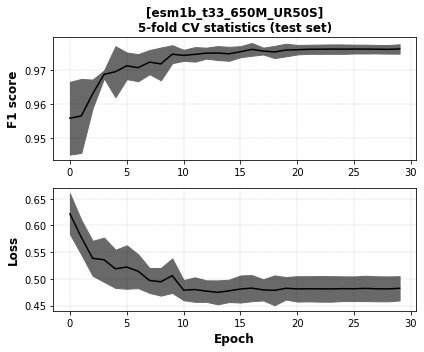

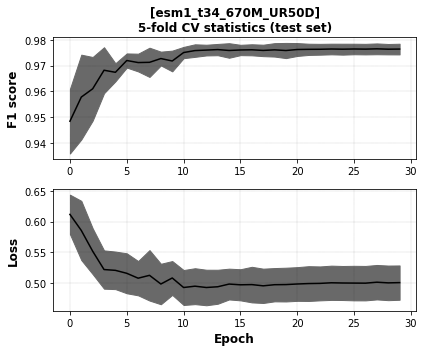

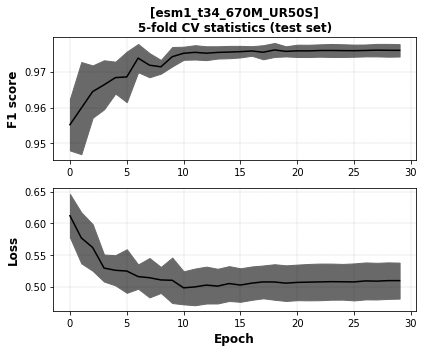

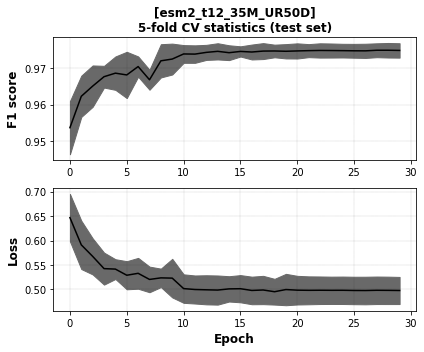

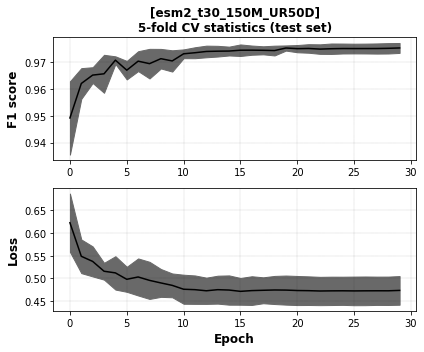

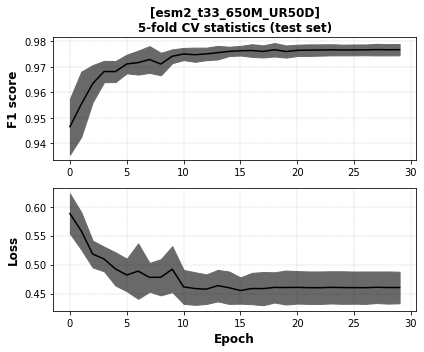

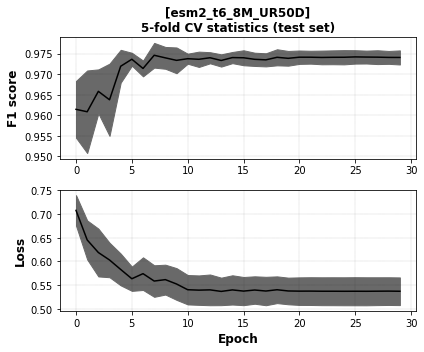

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

model_list = ['esm1b_t33_650M_UR50S', 'esm1_t34_670M_UR50D', 'esm1_t34_670M_UR50S',
                'esm2_t12_35M_UR50D', 'esm2_t30_150M_UR50D', 'esm2_t33_650M_UR50D',
                'esm2_t6_8M_UR50D']

for model_name in model_list:
    list_f1, list_loss = [], []
    for fold in range(1,6):
        df = pd.read_csv('checkpoints_weighted/%s_setB_fold%s.csv'%(model_name, fold))
        list_f1.append(list(df['net_f1_test']))
        list_loss.append(list(df['net_loss_test']))

    test_mean_f1 = np.mean(list_f1, axis=0)
    test_std_f1 = np.std(list_f1, axis=0)

    test_mean_loss = np.mean(list_loss, axis=0)
    test_std_loss = np.std(list_loss, axis=0)

    fig, ax = plt.subplots(2, figsize=(6,5))
    ax[0].plot(range(len(test_mean_f1)), test_mean_f1, label="Training score", color="black")
    ax[0].fill_between(range(len(test_mean_f1)), test_mean_f1 - test_std_f1, test_mean_f1 + test_std_f1, color="dimgrey")
    ax[0].set_ylabel('F1 score', fontsize=12, fontweight='bold')
    ax[0].grid(color='black', linestyle='-.', linewidth=0.1)

    ax[1].plot(range(len(test_mean_loss)), test_mean_loss, label="Training score", color="black")
    ax[1].fill_between(range(len(test_mean_loss)), test_mean_loss - test_std_loss, test_mean_loss + test_std_loss, color="dimgrey")
    ax[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax[1].grid(color='black', linestyle='-.', linewidth=0.1)

    ax[0].set_title('[%s]\n5-fold CV statistics (test set)'%(model_name), fontsize=12, fontweight='bold')
    plt.tight_layout()